In [1]:
from pathlib import Path

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import polars as pl

from src.constant import LABELS
from src.preprocess import load_eeg, process_label, calc_weight
from src.visualization import format_time, plot_eeg

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
list(data_dir.glob("*"))
metadata = pl.read_csv(data_dir / "train.csv")
metadata = process_label(metadata)
metadata = metadata.group_by("eeg_id").agg(
    *[
        pl.col(f"{label}_prob_per_eeg").first().alias(f"{label}_prob")
        for label in LABELS
    ],
    pl.col("weight_per_eeg").first().alias("weight"),
)
display(metadata.head())


def sum_over_labels(labels) -> pl.Expr:
    x = pl.lit(0.0)
    for label in labels:
        x += pl.col(f"pl_{label}_vote")
    return x


df = pl.read_parquet("../data/pseudo_label/eeg022_16ep_sc03c/train_pseudo_label.pqt")
df = (
    df.with_columns(pl.col(f"pl_{label}_vote").exp() for label in LABELS)
    .with_columns(sum_over_labels(LABELS).alias("pl_vote"))
    .with_columns(
        pl.col(f"pl_{label}_vote").truediv(pl.col("pl_vote")).alias(f"pl_{label}_prob")
        for label in LABELS
    )
)


metadata = df.join(metadata, on="eeg_id")
display(metadata.head())

eeg_id,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f64,f64,f64,f64,f64,f64,f64
643036156,0.692308,0.0,0.307692,0.0,0.0,0.0,0.464286
2112845266,0.0,0.0,0.5,0.0,0.0,0.5,0.428571
2203214250,0.0,0.0,0.0,0.0,0.0,1.0,0.035714
4182896996,0.0,0.066667,0.6,0.0,0.0,0.333333,0.535714
3719336260,0.0,0.0,0.0,0.0,0.0,1.0,0.071429


eeg_id,pl_seizure_vote,pl_lpd_vote,pl_gpd_vote,pl_lrda_vote,pl_grda_vote,pl_other_vote,pl_vote,pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob,seizure_prob,lpd_prob,gpd_prob,lrda_prob,grda_prob,other_prob,weight
i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64
643036156,2.152089,0.079249,5.055328,0.011795,0.359007,2.704161,10.361629,0.207698,0.007648,0.487889,0.001138,0.034648,0.260978,0.692308,0.0,0.307692,0.0,0.0,0.0,0.464286
2112845266,0.370523,0.129812,1.304299,0.082245,0.153455,9.693779,11.734114,0.031577,0.011063,0.111154,0.007009,0.013078,0.826119,0.0,0.0,0.5,0.0,0.0,0.5,0.428571
2203214250,0.1192,0.079456,0.023472,0.1882,0.817938,59.808392,61.036659,0.001953,0.001302,0.000385,0.003083,0.013401,0.979877,0.0,0.0,0.0,0.0,0.0,1.0,0.035714
4182896996,0.050538,1.447197,8.351121,0.04542,0.212635,2.611594,12.718507,0.003974,0.113787,0.656612,0.003571,0.016719,0.205338,0.0,0.066667,0.6,0.0,0.0,0.333333,0.535714
3719336260,0.359475,0.062163,0.064262,0.100835,0.344524,24.529339,25.460596,0.014119,0.002442,0.002524,0.00396,0.013532,0.963424,0.0,0.0,0.0,0.0,0.0,1.0,0.071429


pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob
f32,f32,f32,f32,f32,f32
0.047198,0.16262,0.123948,0.069372,0.092169,0.504692


pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob
f32,f32,f32,f32,f32,f32
0.117245,0.109271,0.079733,0.078836,0.118493,0.496421


pl_seizure_prob,pl_lpd_prob,pl_gpd_prob,pl_lrda_prob,pl_grda_prob,pl_other_prob
f32,f32,f32,f32,f32,f32
0.034724,0.128591,0.12502,0.048302,0.091386,0.571976


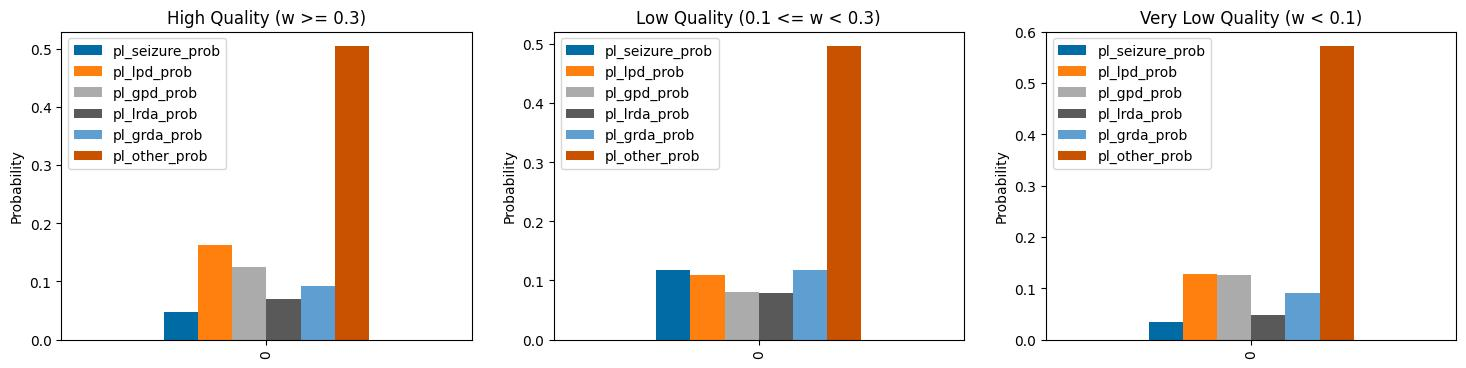

In [5]:

high_quality = metadata.filter(pl.col("weight").ge(0.3)).select(f"pl_{label}_prob" for label in LABELS)
low_quality = metadata.filter(pl.col("weight").lt(0.3).and_(pl.col("weight").ge(0.1))).select(f"pl_{label}_prob" for label in LABELS)
very_low_quality = metadata.filter(pl.col("weight").lt(0.1)).select(f"pl_{label}_prob" for label in LABELS)

display(high_quality.drop("eeg_id").mean())
display(low_quality.drop("eeg_id").mean())
display(very_low_quality.drop("eeg_id").mean())

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
high_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax1)
low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax2)
very_low_quality.drop("eeg_id", "weight").mean().to_pandas().plot.bar(ax=ax3)
ax1.set(title="High Quality (w >= 0.3)", ylabel="Probability")
ax2.set(title="Low Quality (0.1 <= w < 0.3)", ylabel="Probability")
ax3.set(title="Very Low Quality (w < 0.1)", ylabel="Probability")
plt.show()